# Underwater Target Detector

## 1.0 Import

In [107]:
import cv2 as cv

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

from PIL import Image
from skimage.transform import resize, rotate
from keras.objectives import mean_squared_error, categorical_crossentropy
from keras.layers import Input, Convolution2D, Dropout, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, GlobalMaxPooling2D
from keras.models import Model

from sklearn import svm as sklearn_svm
from sklearn.model_selection import cross_val_score

## 2.0 Setting

In [104]:
!ls ../data/snap/

checkerboard  seabed  target


In [109]:
KERNEL_SIZE = 5
HEIGHT, WIDTH = 276, 368

In [105]:
PATH_SNAP = '../data/snap/'
PATH_SEABED = PATH_SNAP + 'seabed/'
PATH_TARGET = PATH_SNAP + 'target/'
PATH_CHECKER = PATH_SNAP + 'checkerboard/'

## 3.0 Data Augmentation

### 3.1 What about our image

In [106]:
img = plt.imread(PATH_TARGET + 'original/G0010020.JPG')

In [44]:
img.shape

(2880, 3840, 3)

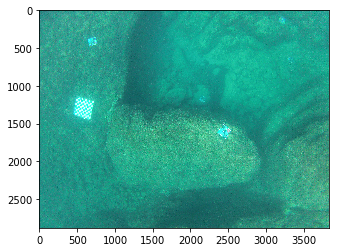

In [45]:
plt.imshow(img)

### 3.2 Resize and create new images (rotate, flip, etc.)

In [46]:
HEIGHT, WIDTH = 276, 368 # new size of the image

In [47]:
# Function that takes 1 image and return 7 new images
def data_augmentation(img):
    # list containing all images
    img_list = []
    
    # resized image because too loud
    img_resized = resize(img, (HEIGHT, WIDTH), anti_aliasing=True, mode='reflect')
    img_list.append(img_resized)
    
    # create 5 images rotated by 54°
    for k in range(1,6):
        rot_img = rotate(img_resized, angle=54*k, mode='reflect')
        img_list.append(rot_img)

    # flip horizontally and vertically
    img_list.append(np.fliplr(img_resized))
    img_list.append(np.flipud(img_resized))
    
    # mixte with flip and rotate
    img_list.append(rotate(np.fliplr(img_resized), angle=90, mode='reflect'))
    img_list.append(rotate(np.flipud(img_resized), angle=90, mode='reflect'))
    
    return img_list

In [48]:
img_list = data_augmentation(img)

### 3.3 Let's plot and see the result

In [49]:
# Function that plot all of our new augmented images
def plot_images_augmented(img_list):
    fig=plt.figure(figsize=(8, 8))
    columns = 3
    rows = 4

    for i, img in zip(range(1, len(img_list) + 1), img_list):
        _ = fig.add_subplot(rows, columns, i)
        _ = plt.imshow(img)
    
    plt.show()

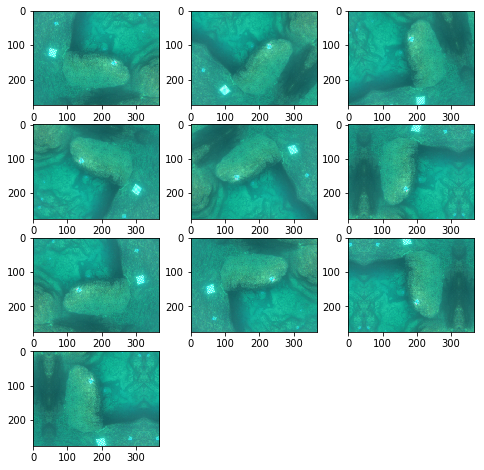

In [50]:
plot_images_augmented(img_list)

### 3.4 Save images into our database

In [51]:
# Giving a folder_in path, it get all images, resize, create new images, and write into folder_out
def data_augmentation_folder(path_folder_in, path_folder_out, plot=False, write=False):

    # walk througout all files in folder_in
    for dirname, dirnames, filenames in os.walk(path_folder_in):
        for filename in filenames:
            cur_path = os.path.join(dirname, filename)

            # launch the data augmentation for each images
            img = plt.imread(cur_path)
            img_list = data_augmentation(img)
            
            if plot:
                plot_images_augmented(img_list)

            if write:
                # write new images into folder_out
                for i, img in zip(range(10), img_list):
                    cur_filename = filename[:-4] + '_' + str(i) + '.JPG'
                    plt.imsave(path_folder_out + cur_filename, img)

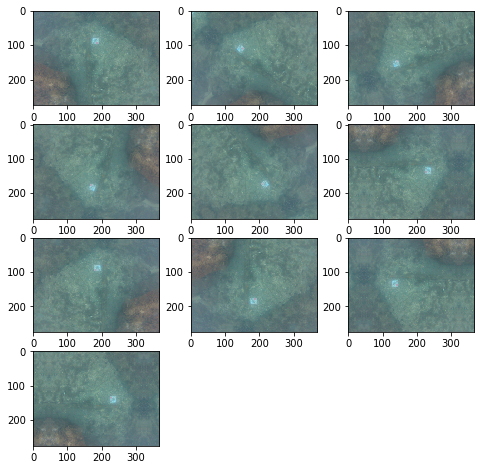

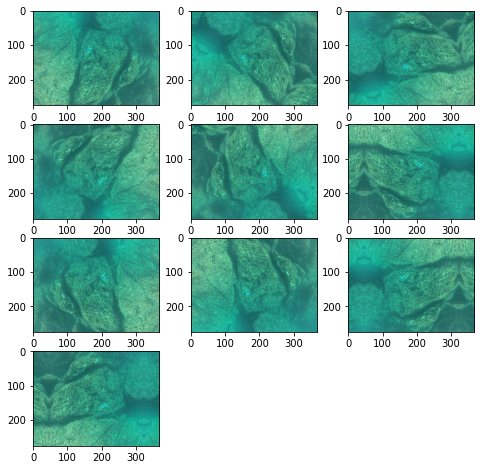

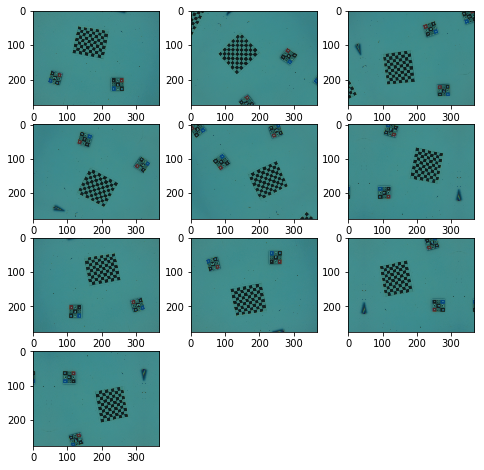

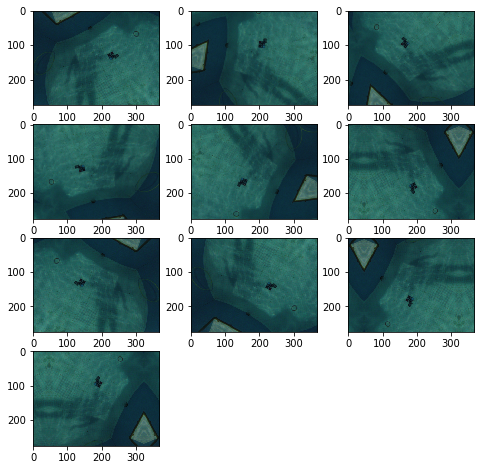

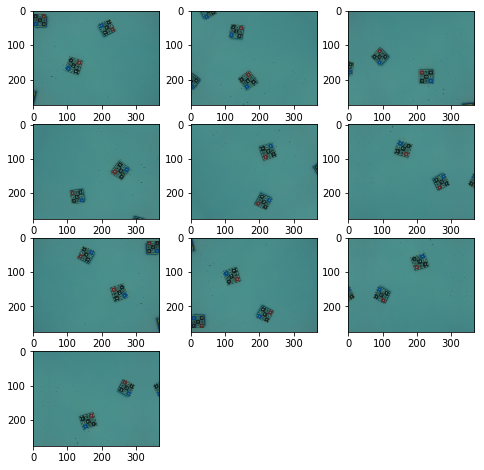

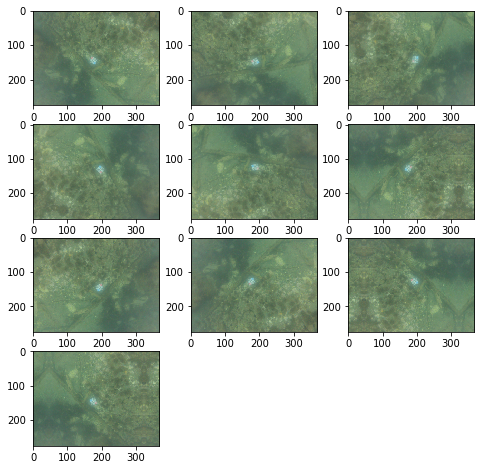

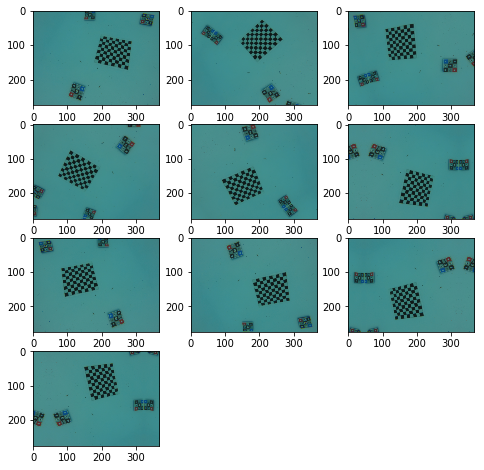

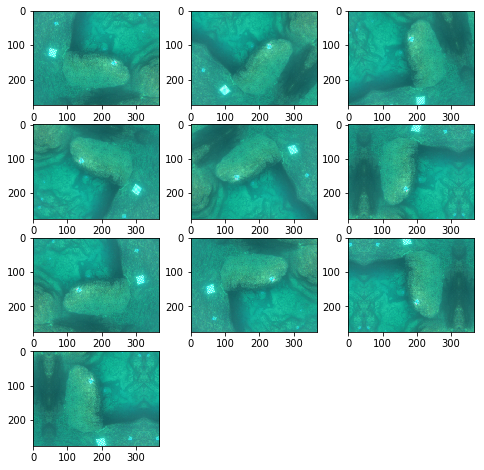

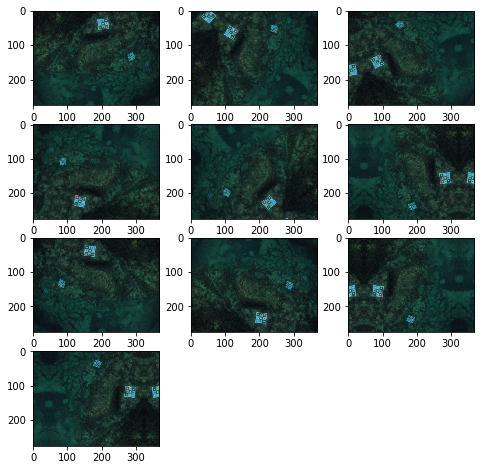

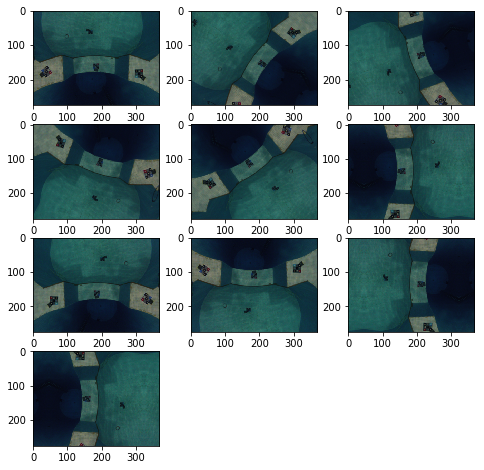

KeyboardInterrupt: 

In [52]:
# Plot all new images created
data_augmentation_folder(PATH_TARGET + 'original/', PATH_TARGET + 'augmented/', plot=True, write=False)

**Do not launch this cell** below if you have already downloaded the augmented images!

In [ ]:
# Create our new data and save it into a sub_folder
data_augmentation_folder(PATH_TARGET + 'original/', PATH_TARGET + 'augmented/', plot=False, write=True)
data_augmentation_folder(PATH_SEABED + 'original/', PATH_SEABED + 'augmented/', plot=False, write=True)
data_augmentation_folder(PATH_CHECKER + 'original/', PATH_CHECKER + 'augmented/', plot=False, write=True)

## 4.0 Box annotation

#### Functions definition

In [53]:
# Function that return the new coord, giving coord of center of target and the rotation
def coord_rotate(x, y, theta):
    # coord for centre of image
    x_0, y_0 = HEIGHT/2, WIDTH/2
    
    y_rot = x_0 + (y - x_0) * math.cos(math.radians(theta)) - (x - y_0) * math.sin(math.radians(theta))
    x_rot = y_0 + (y - x_0) * math.sin(math.radians(theta)) + (x - y_0) * math.cos(math.radians(theta))
    
    return int(x_rot), int(y_rot)

In [54]:
def coord_fliplr(x, y):
    return WIDTH - 1 - x, y

In [55]:
def coord_flipud(x, y):
    return x, HEIGHT - 1 - y

#### Let's see our annotation

Function of plot image with box

In [56]:
# Function that plot image with its box detection
def plot_img_box(img_path, x, y, radius):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    fig, ax = plt.subplots(1)
    ax.imshow(im)

    # create a Rectangle patch
    rect = patches.Rectangle((x-radius, y-radius), radius*2, radius*2, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()

Box coordinates of the first image:

In [57]:
x, y, radius = 234, 153, 10

In [58]:
x_rot, y_rot = coord_rotate(x, y, 54)
x_rot, y_rot

(225, 106)

In [59]:
x_lr, y_lr = coord_fliplr(x, y)
x_lr, y_lr

(133, 153)

In [60]:
x_ud, y_ud = coord_flipud(x, y)
x_ud, y_ud

(234, 122)

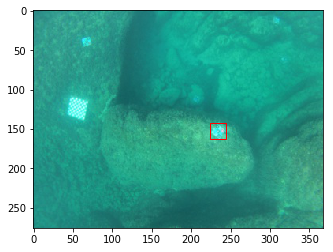

In [61]:
plot_img_box(PATH_TARGET + 'augmented/G0010020_0.JPG', x, y, radius)

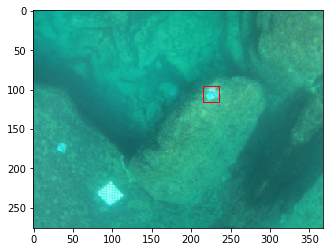

In [62]:
plot_img_box(PATH_TARGET + 'augmented/G0010020_1.JPG', x_rot, y_rot, radius)

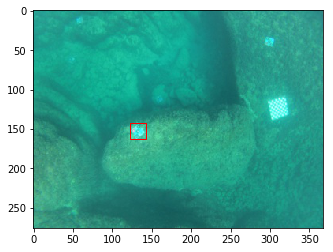

In [63]:
plot_img_box(PATH_TARGET + 'augmented/G0010020_6.JPG', x_lr, y_lr, radius)

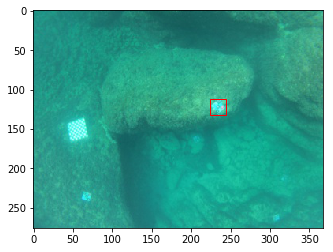

In [64]:
plot_img_box(PATH_TARGET + 'augmented/G0010020_7.JPG', x_ud, y_ud, radius)

#### Get matrix of annotation

In [65]:
PATH_HAND_ANNOTATION = '../data/snap/target/annotation_box.txt'
hand_df = pd.read_csv(PATH_HAND_ANNOTATION, sep='\t')
hand_df.head()

x    y  radius
0  234  153      10
1  152  105       5
2  129  167       8
3  181  164       9
4  163  116       8

In [66]:
hand_arr = hand_df.as_matrix()
hand_arr = hand_arr.tolist()
hand_arr[:5]

/home/xavier/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


[[234, 153, 10], [152, 105, 5], [129, 167, 8], [181, 164, 9], [163, 116, 8]]

In [67]:
def get_all_box_annotation():
    box_label = []
    for elm in hand_arr:
        x, y, radius = elm[0], elm[1], elm[2]

        # add the first img
        box_label.append(elm)

        # add the 5 rotations
        for k in range(1, 6):
            x_rot, y_rot = coord_rotate(x, y, 54*k)
            cur_list = [x_rot, y_rot, radius]
            box_label.append(cur_list)

        # add the fliplr
        x_lr, y_lr = coord_fliplr(x, y)
        cur_list = [x_lr, y_lr, radius]
        box_label.append(cur_list)

        # add the flipud
        x_ud, y_ud = coord_flipud(x, y)
        cur_list = [x_ud, y_ud, radius]
        box_label.append(cur_list)

        # add the mixte fliplr and rotate
        x_lr, y_lr = coord_fliplr(x, y)
        x_rot, y_rot = coord_rotate(x_lr, y_lr, 90)
        cur_list = [x_rot, y_rot, radius]
        box_label.append(cur_list)

        # add the mixte flipud and rotate
        x_ud, y_ud = coord_flipud(x, y)
        x_rot, y_rot = coord_rotate(x_ud, y_ud, 90)
        cur_list = [x_rot, y_rot, radius]
        box_label.append(cur_list)

    return box_label

In [68]:
box_label = get_all_box_annotation()

In [69]:
len(box_label)

270

In [70]:
boxes = np.array(box_label)

In [71]:
boxes.shape

(270, 3)

#### Let's check that!

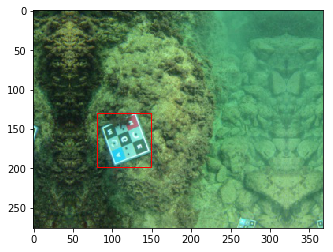

In [72]:
x = 89
plot_img_box(PATH_TARGET + 'augmented/G0010352_9.JPG', box_label[x][0], box_label[x][1], box_label[x][2])

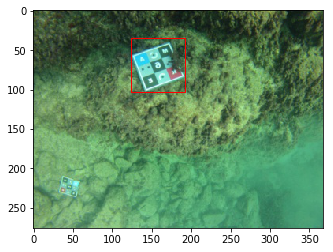

In [73]:
x = 87
plot_img_box(PATH_TARGET + 'augmented/G0010352_7.JPG', box_label[x][0], box_label[x][1], box_label[x][2])

## 5.0 Classification with SVM

### 5.1 Image Processing

In [112]:
def image_preprocessing(path, scaling=False):
    '''
    Preprocess a single image.
    '''
    
    # Open image
    try:
        img = cv.imread(path, 0)#.astype(np.uint8)
    except:
        return None
  
    # Scaling
    if scaling:
        img = cv.resize(img, (WIDTH, HEIGHT), interpolation=cv.INTER_CUBIC)
    
    # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    img = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(img)

    # Median filter
    img = cv.medianBlur(img, KERNEL_SIZE)
  
    # Sobel filtering: apply cv.Sobel to have output dtype = cv.CV_64F (=float64). 
    # then take its absolute and convert to cv2.CV_8U (=uint8).
    sobel64f = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=KERNEL_SIZE)
    abs_sobel64f = np.absolute(sobel64f)
    img = np.uint8(abs_sobel64f)
  
    return img

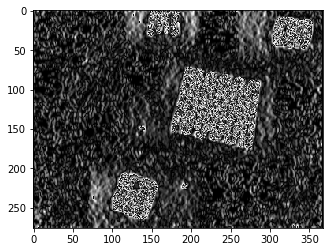

In [113]:
path = '../data/snap/target/original/G0012842.JPG'
img = image_preprocessing(path, True)
plt.imshow(img, cmap='gray')
plt.show()

In [114]:
def get_image_processed(path):
    # Preprocess all images given by path, store them into a NumPy array, and return it

    # TODO : all img to array
    samples = None

    # Walk through the directory
    for dirname, dirnames, filenames in os.walk(path):
        for filename in filenames:
            full_path = os.path.join(dirname, filename)

            # Preprocess the image given by full path 
            new_sample = image_preprocessing(full_path, True).astype(np.float32)
            new_sample.resize(1, HEIGHT * WIDTH)

            # append new samples and labels as rows to the sample and label arrays
            if samples is None:
                samples = new_sample
            else:
                samples = np.append(samples, new_sample, axis=0)
                    
    return samples

In [115]:
seabed_samples = get_image_processed(PATH_SEABED + 'augmented/')
target_samples = get_image_processed(PATH_TARGET + 'augmented/')
checker_samples = get_image_processed(PATH_CHECKER + 'augmented/')
samples = np.vstack([seabed_samples, target_samples, checker_samples])

In [116]:
labels = np.ones(shape=(samples.shape[0],), dtype=np.int64)
labels[:seabed_samples.shape[0]] = 0

### 5.2 SVM training

In [117]:
# svm creation. C is determined with svm.trainAuto(samples, cv.ml.ROW_SAMPLE, labels)
C = 0.1
svm = cv.ml.SVM_create()
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setType(cv.ml.SVM_C_SVC)
svm.setC(C)

In [ ]:
# Measure classification performance through k-cross-validation (k=5)
svm2 = sklearn_svm.SVC(kernel='linear', C=C)
scores = cross_val_score(svm2, samples, labels, cv=5)
print("Scores:", scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), 2 * scores.std()))

In [118]:
# Training
svm.train(samples, cv.ml.ROW_SAMPLE, labels)
#svm.trainAuto(samples, cv.ml.ROW_SAMPLE, labels)
pass

### 5.3 Classification

In [119]:
def is_good(path, svm=svm): 
    '''
    Return True if the image given by 'path' has at least a checkerboard or
    a target inside it (possibly both), or False otherwise.
    '''
    img = image_preprocessing(path, scaling=True).reshape(1, HEIGHT * WIDTH).astype(np.float32)
    response = svm.predict(img)[1][0, 0]
    return response == 1

## 6.0 Box detection

### 6.1 Preprocess data (boxes and images)

#### Boxes

In [282]:
boxes.shape

(270, 3)

In [283]:
out_boxes = boxes[:200]
test_boxes = boxes[200:]

#### Images

In [296]:
def folder_images_array(path):
    imgs = []
    for dirname, dirnames, filenames in os.walk(path):
        for filename in filenames:
            full_path = os.path.join(dirname, filename)
            imgs.append(np.expand_dims(plt.imread(full_path), axis=0))
    return np.concatenate(imgs, axis=0)

In [297]:
img_array = folder_images_array(PATH_TARGET + 'augmented/')
img_array.shape

(270, 276, 368, 3)

### 6.2 Pre-computing representations

Before designing the object detection model itself, we will pre-process all the dataset, by using a ResNet50, to project the images as spatial maps in a (9, 12, 2048) dimensional space once and for all.

The output size is (batch_size, 276/32 = 9, 368/32 = 12, 2048). The size of images are divided by 32 because of the 5 MaxPooling of ResNet50 (2⁵=32).

In [293]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model

model = ResNet50(include_top=False)
input = model.layers[0].input

# Remove the average pooling layer
output = model.layers[-2].output
headless_conv = Model(inputs=input, outputs=output)

/home/dadou/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


#### Predicting on a batch of images

In [315]:
from keras.applications.imagenet_utils import preprocess_input

def predict_batch(model, img_array):
    img_list = [preprocess_input(img) for img in img_array]
    img_list = np.asarray(img_list)    
    
    return model.predict(img_list)

In [316]:
output = predict_batch(headless_conv, img_array)
print("output shape", output.shape)

output shape (270, 9, 12, 2048)


In [320]:
inputs = output[:200]
test_inputs = output[200:]

### 6.3 Localization Model

In [325]:
def classif_and_loc():
    model_input = Input(shape=(9,12,2048))
    y = Convolution2D(4, (1, 1), activation='relu', name='hidden_conv')(model_input)
    y = Flatten()(y)
    y = Dropout(0.2)(y)
    head_boxes = Dense(3, name="head_boxes")(y)

    model = Model(model_input, output=head_boxes, name="resnet_loc")
    model.compile(optimizer="adam", loss="mse", loss_weights=[1/(HEIGHT*WIDTH)]) 
    
    return model

In [326]:
model = classif_and_loc()

/home/dadou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., name="resnet_loc", outputs=Tensor("he...)`
  


In [327]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 9, 12, 2048)       0         
_________________________________________________________________
hidden_conv (Conv2D)         (None, 9, 12, 4)          8196      
_________________________________________________________________
flatten_9 (Flatten)          (None, 432)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 432)               0         
_________________________________________________________________
head_boxes (Dense)           (None, 3)                 1299      
Total params: 9,495
Trainable params: 9,495
Non-trainable params: 0
_________________________________________________________________


In [328]:
history = model.fit(x=inputs, y=out_boxes, 
                    validation_data=(test_inputs, test_boxes),
                    batch_size=32, epochs=30, verbose=2)

Train on 200 samples, validate on 70 samples
Epoch 1/30
 - 4s - loss: 0.1680 - val_loss: 0.1088
Epoch 2/30
 - 0s - loss: 0.0548 - val_loss: 0.0322
Epoch 3/30
 - 0s - loss: 0.0404 - val_loss: 0.0322
Epoch 4/30
 - 0s - loss: 0.0231 - val_loss: 0.0311
Epoch 5/30
 - 0s - loss: 0.0255 - val_loss: 0.0270
Epoch 6/30
 - 0s - loss: 0.0200 - val_loss: 0.0259
Epoch 7/30
 - 0s - loss: 0.0215 - val_loss: 0.0249
Epoch 8/30
 - 0s - loss: 0.0182 - val_loss: 0.0253
Epoch 9/30
 - 0s - loss: 0.0194 - val_loss: 0.0251
Epoch 10/30
 - 0s - loss: 0.0186 - val_loss: 0.0252
Epoch 11/30
 - 0s - loss: 0.0172 - val_loss: 0.0255
Epoch 12/30
 - 0s - loss: 0.0171 - val_loss: 0.0255
Epoch 13/30
 - 0s - loss: 0.0172 - val_loss: 0.0255
Epoch 14/30
 - 0s - loss: 0.0163 - val_loss: 0.0256
Epoch 15/30
 - 0s - loss: 0.0177 - val_loss: 0.0258
Epoch 16/30
 - 0s - loss: 0.0165 - val_loss: 0.0258
Epoch 17/30
 - 0s - loss: 0.0160 - val_loss: 0.0259
Epoch 18/30
 - 0s - loss: 0.0159 - val_loss: 0.0263
Epoch 19/30
 - 0s - loss: 0.

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

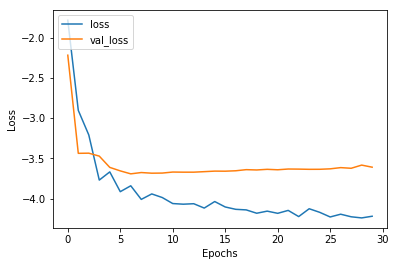

In [370]:
plt.plot(np.log(history.history["loss"]), label="loss")
plt.plot(np.log(history.history["val_loss"]), label="val_loss")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Compute the previous function on the whole train / test set
def compute_acc(train=True):
    if train:
        beg, end = 0, (9 * len(annotations) // 10)
        split_name = "train"
    else:
        beg, end = (9 * len(annotations)) // 10, len(annotations) 
        split_name = "test"
    res = model.predict(reprs[beg:end])
    outputs = []
    for index, (classes, boxes) in enumerate(zip(res[0], res[1])):
        output = interpret_output(classes, boxes,
                                  img_size=annotations[index]["size"])
        outputs.append(output)
    
    acc, iou, valid = accuracy_and_iou(outputs, annotations[beg:end],
                                       threshold=0.5)
    
    print('{} acc: {:0.3f}, mean iou: {:0.3f}, acc_valid: {:0.3f}'.format(
            split_name, acc, iou, valid))

In [329]:
compute_acc(train=True)
compute_acc(train=False)

NameError: name 'compute_acc' is not defined

## 7.0 Model testing

In [120]:
def classification_testing(path):
    for dirname, dirnames, filenames in os.walk(path):
        for filename in filenames:
            full_path = os.path.join(dirname, filename)
            print('Image: {} - Has a target or a checkbord in it?: {}'.format(full_path, is_good(full_path)))

In [121]:
test_path = '../data/snap/target/original/' # FIXME:replace with the path where your test images are
classification_testing(test_path)

Image: ../data/snap/target/original/G0010516.JPG - Has a target or a checkbord in it?: True
Image: ../data/snap/target/original/G0010088.JPG - Has a target or a checkbord in it?: True
Image: ../data/snap/target/original/G0013010.JPG - Has a target or a checkbord in it?: True
Image: ../data/snap/target/original/G0050669.JPG - Has a target or a checkbord in it?: True
Image: ../data/snap/target/original/G0012909.JPG - Has a target or a checkbord in it?: True
Image: ../data/snap/target/original/G0010450.JPG - Has a target or a checkbord in it?: True
Image: ../data/snap/target/original/G0012842.JPG - Has a target or a checkbord in it?: True
Image: ../data/snap/target/original/G0010020.JPG - Has a target or a checkbord in it?: True
Image: ../data/snap/target/original/G0010740.JPG - Has a target or a checkbord in it?: True
Image: ../data/snap/target/original/G0010066.JPG - Has a target or a checkbord in it?: True
Image: ../data/snap/target/original/G0010469.JPG - Has a target or a checkbord i

In [330]:
res = model.predict(test_inputs)

In [332]:
res[:5]

array([[141.58849  , 101.24563  ,  15.103074 ],
       [170.92772  , 117.7646   ,   6.7851176],
       [182.40376  , 132.26976  ,  14.963562 ],
       [171.45023  , 134.51845  ,  12.465078 ],
       [173.98668  , 125.112434 ,   2.1940129]], dtype=float32)

In [333]:
res_img = img_array[200:]

In [334]:
res_img.shape

(70, 276, 368, 3)

In [357]:
def plot_img_box_2(img_arr, x, y, radius):
    fig, ax = plt.subplots(1)
    ax.imshow(img_arr)

    # create a Rectangle patch
    rect = patches.Rectangle((x-radius, y-radius), radius*2, radius*2, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()

In [364]:
# Function that plot all of our new augmented images
def plot_images_res(img_list, res):
    for i, img, cur_res in zip(range(1, 10), img_list, res):
        x, y, radius = cur_res[0], cur_res[1], cur_res[2]        
        plot_img_box_2(img, x, y, radius)
        
    plt.show()

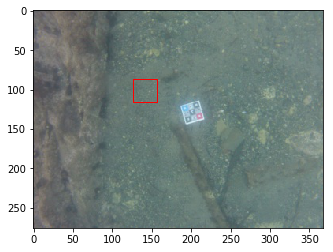

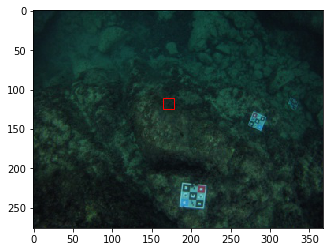

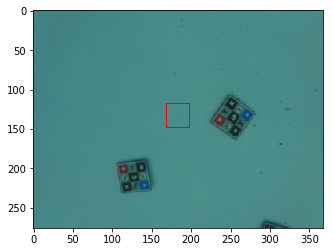

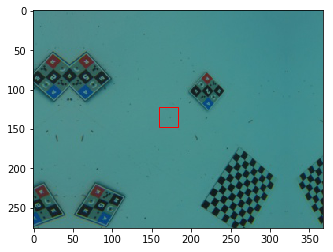

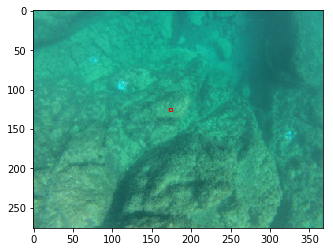

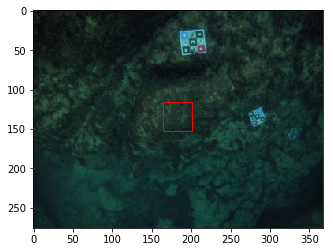

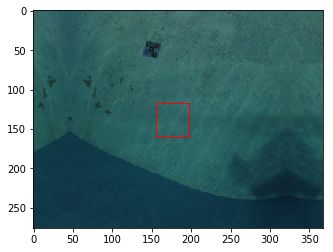

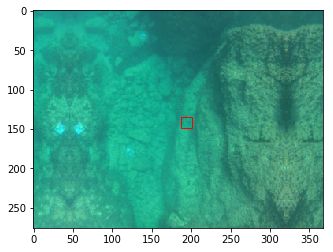

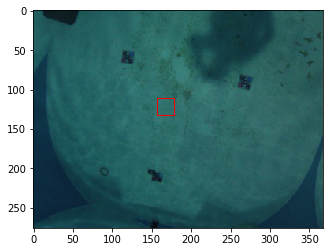

In [365]:
plot_images_res(res_img, res)

It does not give good predictions for the localization of the target. On another side, it seems to give good predictions on the radius.